# Using text and neural network features

Learn about some more advance capabilities of TF-DF, including how to deal with the natural language features. We will learn the following:

1. Train a random forest that consumes text features natively as categorical sets


## Use raw text as features

TF-DF can conusme categorical-set features natively. Categorical sets represent text features as bags of words (or n-grams). Example:
- "the little blue dog" -> {"the", "little", "blue", "dog"}

We will train a random forest on the standford sentiment treebank (sst) dataset.

Object of this dataset is to classify sentences as carrying a positive or negative sentiment. Youll will use the binary classification version of the dataset curated in tensorflow datasets

**Note**: categorical-set features can be expensive to train. We will be using random forest with 20 trees (might test more)

url: https://www.tensorflow.org/decision_forests/tutorials/intermediate_colab




## Setup

In [1]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

In [2]:
# load the dataset
import tensorflow_datasets as tfds
all_ds = tfds.load("glue/sst2")

/Users/eric/keras-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-12-26 09:57:16.742806: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 1/1 [00:01<00:00,  1.20s/ url]

Dl Completed...: 100%|██████████| 1/1 [00:01<00:00,  1.38s/ url]
2022-12-26 09:57:33.608829: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-26 09:57:33.609562: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Dataset glue downloaded and prepared to /Users/eric/tensorflow_datasets/glue/sst2/2.0.0. Subsequent calls will reuse this data.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [3]:
# display the first 3 examples of the test fold
for example in all_ds["test"].take(3):
    print({attr_name: attr_tensor.numpy() for attr_name, attr_tensor in example.items()})

{'idx': 163, 'label': -1, 'sentence': b'not even the hanson brothers can save it'}
{'idx': 131, 'label': -1, 'sentence': b'strong setup and ambitious goals fade as the film descends into unsophisticated scare tactics and b-film thuggery .'}
{'idx': 1579, 'label': -1, 'sentence': b'too timid to bring a sense of closure to an ugly chapter of the twentieth century .'}


2022-12-26 09:59:27.904646: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-26 09:59:27.926187: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


The dataset is modified as follows:
1. The raw labels are integers in {-1, 1} but the learning algorithm expects postive integer labels {0, 1}. Therefore the labels are transformed as following: new_labels = (orginal_labels + 1) / 2
2. A batch-size of 64 is applied to make reading the dataset more efficient
3. The sentence attribute needs to be tokenized. Example "hello world" -> ["hello", "world"]

**Note:** This example doesnt use the test split of dataset as it does not have labels. If the split had labels, you could concatenate the validation fold into the train one 

Some decision forest leanring algorithms do not need validation dataset (eg Random Forests) while others do (Gradient boosted trees in some cases). Since easch learning algorithm under tf-df can use validation data differently, tf-df handles train/validation splits internally. 

When you have a training and validation sets, They can always be concatenated as input to the learning algorithm

In [4]:
def prepare_dataset(example):
    label = (example["label"] + 1) // 2
    return {"sentance" : tf.strings.split(example["sentence"])}, label

train_ds = all_ds["train"].batch(100).map(prepare_dataset)
test_ds = all_ds["validation"].batch(100).map(prepare_dataset)

Finally train and evaluate the model as usual. 

TF-DF automatically detects multi-valued categorical features as categorical-set

In [6]:
# specify the model
model_1 = tfdf.keras.RandomForestModel(num_trees=30, verbose=2)

# train the model
model_1.fit(x=train_ds)

Use 8 thread(s) for training
Use /var/folders/sk/f7k402kx1wvdmcz91gdz6hs00000gn/T/tmp1tb0fuw3 as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'sentance': tf.RaggedTensor(values=Tensor("data:0", shape=(None,), dtype=string), row_splits=Tensor("data_1:0", shape=(None,), dtype=int64))}
Label: Tensor("data_2:0", shape=(None,), dtype=int64)
Weights: None
Normalized tensor features:
 {'sentance': SemanticTensor(semantic=<Semantic.CATEGORICAL_SET: 4>, tensor=tf.RaggedTensor(values=Tensor("data:0", shape=(None,), dtype=string), row_splits=Tensor("data_1:0", shape=(None,), dtype=int64)))}


2022-12-26 10:12:12.802917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Training dataset read in 0:00:02.691408. Found 67349 examples.
Training model...
Standard output detected as not visible to the user e.g. running in a notebook. Creating a training log redirection. If training get stuck, try calling tfdf.keras.set_training_logs_redirection(False).


[INFO kernel.cc:813] Start Yggdrasil model training
[INFO kernel.cc:814] Collect training examples
[INFO kernel.cc:422] Number of batches: 674
[INFO kernel.cc:423] Number of examples: 67349
[INFO data_spec_inference.cc:303] 12816 item(s) have been pruned (i.e. they are considered out of dictionary) for the column sentance (2000 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:836] Training dataset:
Number of records: 67349
Number of columns: 2

Number of columns by type:
	CATEGORICAL_SET: 1 (50%)
	CATEGORICAL: 1 (50%)

Columns:

CATEGORICAL_SET: 1 (50%)
	0: "sentance" CATEGORICAL_SET has-dict vocab-size:2001 num-oods:3595 (5.33787%) most-frequent:"the" 27205 (40.3941%)

CATEGORICAL: 1 (50%)
	1: "__LABEL" CATEGORICAL integerized vocab-size:3 no-ood-item

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the type was not automat

Model trained in 0:01:46.490473
Compiling model...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


2022-12-26 10:14:01.100667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-26 10:14:01.165209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


in previous logs, note the sentence is categorical_set feature

The model is evaluated as usual

In [7]:
model_1.compile(metrics=["accuracy"])
evaluation = model_1.evaluate(test_ds)

print(f"BinaryCrossentropyloss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")

9/9 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.7661
BinaryCrossentropyloss: 0.0
Accuracy: 0.7660551071166992


2022-12-26 10:16:34.620173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


training logs

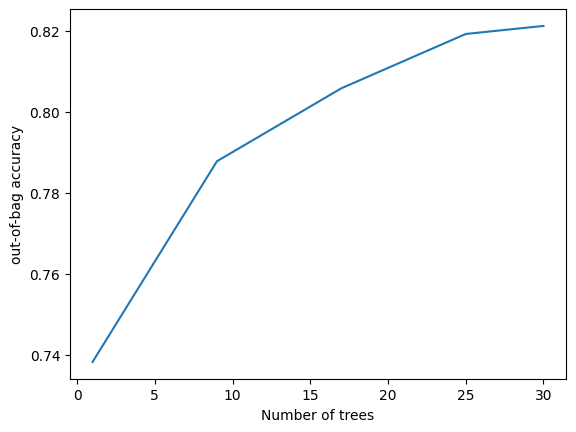

In [9]:
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("out-of-bag accuracy")
pass